In [2]:
import torch
import os

In [3]:
# Re-import or define your dataset class if not already present
from torch.utils.data import DataLoader

class PaddedSegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.filenames = sorted([
            f for f in os.listdir(images_dir)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.images_dir, fname)
        mask_path = os.path.join(self.masks_dir, os.path.splitext(fname)[0] + ".png")
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        target_h, target_w = 640, 1024
        w, h = image.size
        if h < target_h:
            pad_h = target_h - h
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            padding = (0, pad_top, 0, pad_bottom)
            image = TF.pad(image, padding, fill=0)
            mask = TF.pad(mask, padding, fill=0)
        image_tensor = TF.to_tensor(image)
        mask_np = np.array(mask, dtype=np.uint8)
        mask_np = np.where(mask_np == 255, 2, np.where(mask_np == 127, 1, 0))
        mask_tensor = torch.from_numpy(mask_np).long()
        return image_tensor, mask_tensor

# Path to test set
test_dataset = PaddedSegmentationDataset(
    images_dir=r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\images",
    masks_dir=r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\masks"
)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

In [4]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from safetensors.torch import load_file
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 3

from transformers import SegformerForSemanticSegmentation, SegformerConfig
from safetensors.torch import load_file

# Load config
segformer_config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b2-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label={0: "background", 1: "crack", 2: "pothole"},
    label2id={"background": 0, "crack": 1, "pothole": 2}
)

# ⚠️ DO NOT use from_pretrained (it will try to torch.load)
segformer = SegformerForSemanticSegmentation(segformer_config)

# Load weights from safetensors
state_dict = load_file(
    r"C:\Users\SHREY\Desktop\gnctd\segformer_B2_best.safetensors",
    device="cuda" if torch.cuda.is_available() else "cpu"
)
segformer.load_state_dict(state_dict)

segformer.to(device).eval()

# --- Load UNet (ResNet34) ---
unet_resnet = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
)
unet_resnet.load_state_dict(load_file(
    r"C:\Users\SHREY\Desktop\gnctd\last_model.safetensors",
    device="cuda" if torch.cuda.is_available() else "cpu"
))
unet_resnet.to(device).eval()

# --- Load UNet (MobileNetV2) ---
unet_mobilenet = smp.Unet(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES
)
unet_mobilenet.load_state_dict(load_file(
    r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_60.safetensors",
    device="cuda" if torch.cuda.is_available() else "cpu"
))
unet_mobilenet.to(device).eval()

# --- Preprocessing functions ---
def preprocess_unet_image(img_path):
    image = Image.open(img_path).convert("RGB")
    w, h = image.size
    if h < 640:
        pad_h = 640 - h
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        image = transforms.functional.pad(image, (0, pad_top, 0, pad_bottom), fill=0)
    tensor = transforms.functional.to_tensor(image)
    return tensor.unsqueeze(0)  # shape: (1, 3, 640, W)

def preprocess_segformer_image(img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),  # No normalization
    ])
    return transform(image).unsqueeze(0)  # shape: (1, 3, 512, 512)

# --- Ensemble Prediction ---
@torch.no_grad()
def ensemble_predict(img_path):
    # Preprocess inputs
    img_unet = preprocess_unet_image(img_path).to(device)
    img_segformer = preprocess_segformer_image(img_path).to(device)

    # UNet (ResNet34)
    out_resnet = unet_resnet(img_unet)
    prob_resnet = F.softmax(out_resnet, dim=1)

    # UNet (MobileNetV2)
    out_mobilenet = unet_mobilenet(img_unet)
    prob_mobilenet = F.softmax(out_mobilenet, dim=1)

    # SegFormer-B2
    out_segformer = segformer(pixel_values=img_segformer).logits
    out_segformer = F.interpolate(out_segformer, size=(640, 1024), mode="bilinear", align_corners=False)
    prob_segformer = F.softmax(out_segformer, dim=1)

    # Bagging via averaging
    avg_prob = (prob_resnet + prob_mobilenet + prob_segformer) / 3
    pred_mask = torch.argmax(avg_prob, dim=1)

    return pred_mask.squeeze(0).cpu().numpy()  # Final predicted mask (H, W)


📊 Ensemble Performance:
Pixel Accuracy: 0.9883
Per-class Accuracy:
  Background: 0.9905
  Crack: 0.8465
  Pothole: 0.7733
IoU per class:
  Background: 0.9883
  Crack: 0.4226
  Pothole: 0.6783
Mean IoU: 0.6964

📋 Normalized Confusion Matrix (row-wise):
Background: 0.9905  0.0089  0.0006
Crack     : 0.1509  0.8465  0.0026
Pothole   : 0.1873  0.0394  0.7733


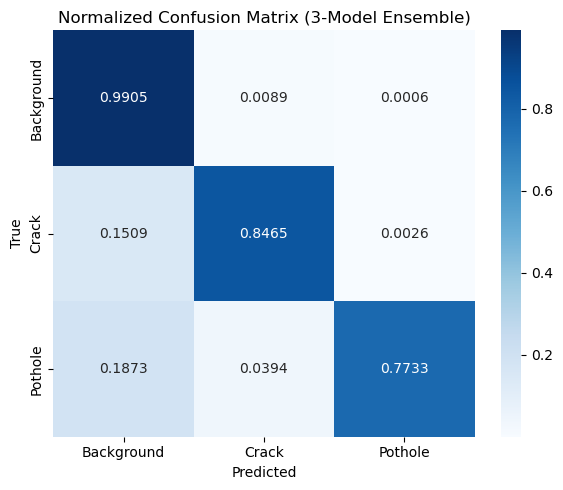

In [9]:
from tqdm import tqdm
import torch
import torchvision.transforms.functional as TF
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from safetensors.torch import load_file

# --- Constants ---
CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load Models ---
def load_models():
    # ✅ SegFormer-B2 (from safetensors)
    config = SegformerConfig.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512",
        num_labels=NUM_CLASSES,
        id2label={0: "background", 1: "crack", 2: "pothole"},
        label2id={"background": 0, "crack": 1, "pothole": 2}
    )
    segformer = SegformerForSemanticSegmentation(config)
    segformer.load_state_dict(load_file(
        r"C:\Users\SHREY\Desktop\gnctd\segformer_B2_best.safetensors",
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
    segformer.to(device).eval()

    # ✅ UNet - ResNet34 (from safetensors)
    unet_r34 = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES)
    unet_r34.load_state_dict(load_file(
        r"C:\Users\SHREY\Desktop\gnctd\last_model.safetensors",
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
    unet_r34.to(device).eval()

    # ✅ UNet - MobileNetV2 (from safetensors)
    unet_mbv2 = smp.Unet("mobilenet_v2", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES)
    unet_mbv2.load_state_dict(load_file(
        r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_60.safetensors",
        device="cuda" if torch.cuda.is_available() else "cpu"
    ))
    unet_mbv2.to(device).eval()

    return segformer, unet_r34, unet_mbv2

# --- Evaluation Function ---
@torch.no_grad()
def evaluate_ensemble(segformer, unet_r34, unet_mbv2, dataloader):
    all_preds = []
    all_labels = []

    for images, masks in tqdm(dataloader, desc="🔍 Evaluating Ensemble", leave=False):
        images, masks = images.to(device), masks.to(device)

        # SegFormer
        out_segformer = segformer(pixel_values=images).logits
        out_segformer = F.interpolate(out_segformer, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        prob_segformer = F.softmax(out_segformer, dim=1)

        # UNet ResNet
        prob_r34 = F.softmax(unet_r34(images), dim=1)

        # UNet MobileNetV2
        prob_mbv2 = F.softmax(unet_mbv2(images), dim=1)

        # Ensemble - Bagging via Average
        avg_prob = (prob_segformer + prob_r34 + prob_mbv2) / 3
        preds = torch.argmax(avg_prob, dim=1)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

    # Convert to numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    # Print metrics
    print("\n📊 Ensemble Performance:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Confusion Matrix - Normalized
    cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)
    print("\n📋 Normalized Confusion Matrix (row-wise):")
    for i, row in enumerate(cm_norm):
        print(f"{CLASS_NAMES[i]:<10}: " + '  '.join(f"{val:.4f}" for val in row))

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Normalized Confusion Matrix (3-Model Ensemble)")
    plt.tight_layout()
    plt.show()

# --- Run Everything ---
segformer, unet_r34, unet_mbv2 = load_models()
evaluate_ensemble(segformer, unet_r34, unet_mbv2, test_loader)

In [10]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import SegformerConfig, SegformerForSemanticSegmentation
from safetensors.torch import load_file
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load All 3 Models ---
def load_ensemble_models():
    # SegFormer-B2
    config = SegformerConfig.from_pretrained(
        "nvidia/segformer-b2-finetuned-ade-512-512",
        num_labels=NUM_CLASSES,
        id2label={0: "background", 1: "crack", 2: "pothole"},
        label2id={"background": 0, "crack": 1, "pothole": 2}
    )
    segformer = SegformerForSemanticSegmentation(config)
    segformer.load_state_dict(load_file(
        r"C:\Users\SHREY\Desktop\gnctd\segformer_B2_best.safetensors",
        device=device.type
    ))
    segformer.to(device).eval()

    # UNet - ResNet34
    unet = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES)
    unet.load_state_dict(load_file(
        r"C:\Users\SHREY\Desktop\gnctd\last_model.safetensors",
        device=device.type
    ))
    unet.to(device).eval()

    # UNet - MobileNetV2
    mobilenet_unet = smp.Unet("mobilenet_v2", encoder_weights="imagenet", in_channels=3, classes=NUM_CLASSES)
    mobilenet_unet.load_state_dict(load_file(
        r"C:\Users\SHREY\Desktop\gnctd\models_mobilenetv2\model_epoch_60.safetensors",
        device=device.type
    ))
    mobilenet_unet.to(device).eval()

    return unet, segformer, mobilenet_unet

# --- Evaluation with Majority Voting ---
@torch.no_grad()
def ensemble_majority_voting_eval(dataloader, unet, segformer, mobilenet_unet, visualize=False, num_visuals=3):
    all_preds = []
    all_labels = []
    visual_count = 0

    for images, masks in tqdm(dataloader, desc="🔍 Evaluating Majority Voting (3 Models)", leave=False):
        images, masks = images.to(device), masks.to(device)

        for i in range(images.shape[0]):
            image = images[i].unsqueeze(0)  # (1, 3, H, W)
            mask = masks[i].cpu().numpy()

            # UNet (ResNet34)
            out_unet = unet(image)
            pred_unet = torch.argmax(F.softmax(out_unet, dim=1), dim=1)

            # SegFormer-B2
            resized_img = F.interpolate(image, size=(512, 512), mode="bilinear", align_corners=False)
            logits_segformer = segformer(pixel_values=resized_img).logits
            logits_segformer = F.interpolate(logits_segformer, size=image.shape[-2:], mode="bilinear", align_corners=False)
            pred_segformer = torch.argmax(F.softmax(logits_segformer, dim=1), dim=1)

            # UNet (MobileNetV2)
            out_mobilenet = mobilenet_unet(image)
            pred_mobilenet = torch.argmax(F.softmax(out_mobilenet, dim=1), dim=1)

            # Majority voting
            stacked_preds = torch.stack([pred_unet, pred_segformer, pred_mobilenet], dim=0)
            voted_pred, _ = torch.mode(stacked_preds, dim=0)
            pred_mask = voted_pred.squeeze(0).cpu().numpy()

            all_preds.extend(pred_mask.flatten())
            all_labels.extend(mask.flatten())

            # Optional visualization
            if visualize and visual_count < num_visuals:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES - 1)
                plt.title("Voted Prediction")
                plt.axis('off')

                plt.tight_layout()
                plt.show()
                visual_count += 1

    # --- Metrics ---
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))

    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Majority Voting Ensemble Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\n📋 Normalized Confusion Matrix (row-wise):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Majority Voting (3 Models)")
    plt.tight_layout()
    plt.show()

🔍 Evaluating Majority Voting (3 Models):   0%|                                                 | 0/28 [00:00<?, ?it/s]

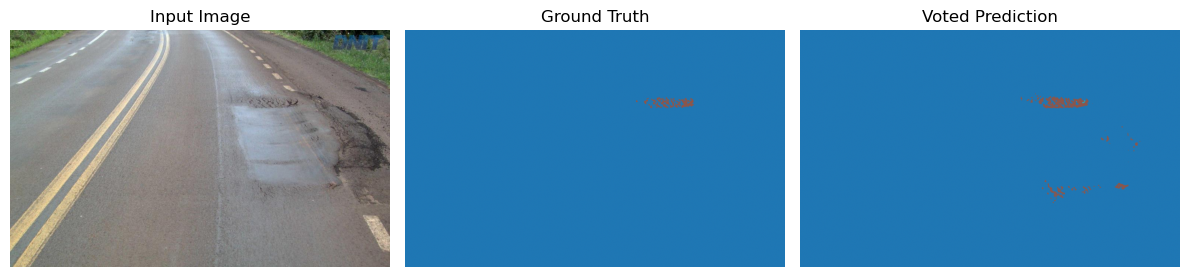

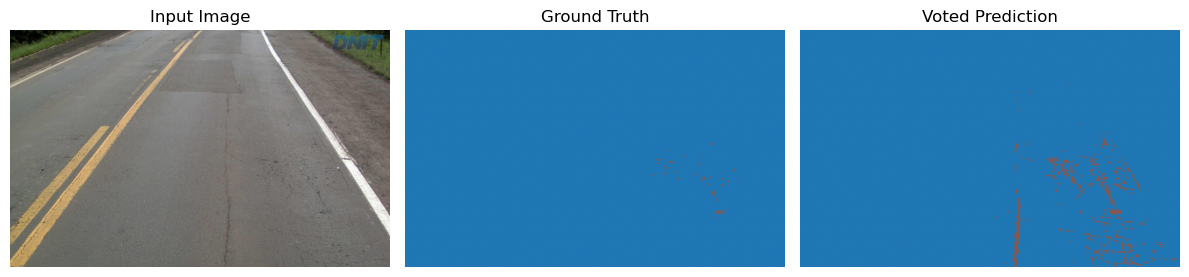

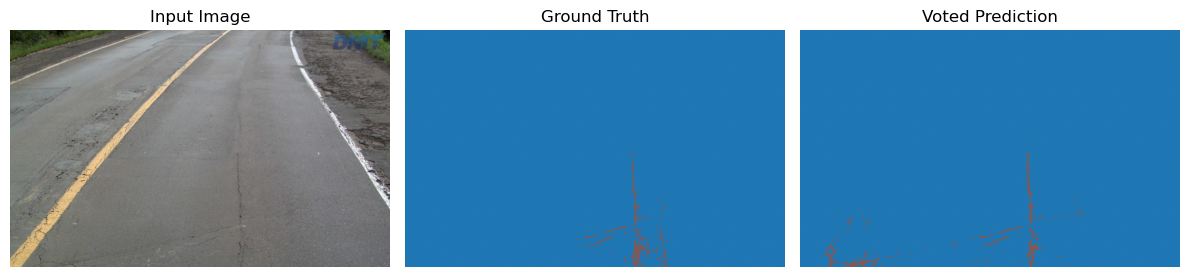


📊 Majority Voting Ensemble Metrics:
Pixel Accuracy: 0.9875
Per-class Accuracy:
  Background: 0.9895
  Crack: 0.8522
  Pothole: 0.8021
IoU per class:
  Background: 0.9875
  Crack: 0.4070
  Pothole: 0.6852
Mean IoU: 0.6932

📋 Normalized Confusion Matrix (row-wise):
Background: 0.9895  0.0097  0.0007
Crack     : 0.1456  0.8522  0.0022
Pothole   : 0.1606  0.0372  0.8021


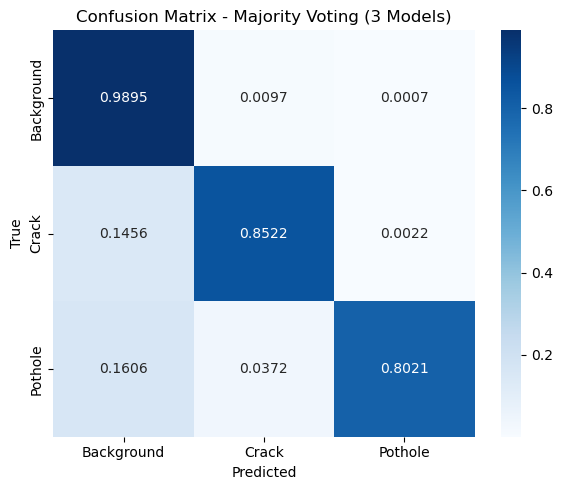

In [11]:
unet, segformer, mobilenet_unet = load_ensemble_models()
ensemble_majority_voting_eval(test_loader, unet, segformer, mobilenet_unet, visualize=True, num_visuals=3)

In [4]:
@torch.no_grad()
def evaluate_weighted_ensemble(segformer, unet_r34, unet_mbv2, dataloader):
    # Pre-computed Mean IoUs (Update if you have new ones for B2 etc.)
    iou_mnv2 = 0.6637
    iou_rn32 = 0.6985
    iou_segformer = 0.6189

    total = iou_mnv2 + iou_rn32 + iou_segformer
    w_mnv2 = iou_mnv2 / total
    w_rn32 = iou_rn32 / total
    w_seg = iou_segformer / total

    print(f"\n📌 Using Weights => ResNet34: {w_rn32:.4f}, MNV2: {w_mnv2:.4f}, SegFormer-B2: {w_seg:.4f}")

    all_preds = []
    all_labels = []

    for images, masks in tqdm(dataloader, desc="🔍 Evaluating Weighted Ensemble", leave=False):
        images, masks = images.to(device), masks.to(device)

        # SegFormer-B2
        resized_img = F.interpolate(images, size=(512, 512), mode="bilinear", align_corners=False)
        out_segformer = segformer(pixel_values=resized_img).logits
        out_segformer = F.interpolate(out_segformer, size=images.shape[-2:], mode="bilinear", align_corners=False)
        prob_segformer = F.softmax(out_segformer, dim=1)

        # UNet - ResNet34
        prob_r34 = F.softmax(unet_r34(images), dim=1)

        # UNet - MobileNetV2
        prob_mbv2 = F.softmax(unet_mbv2(images), dim=1)

        # Weighted Averaging
        weighted_prob = (w_seg * prob_segformer) + (w_rn32 * prob_r34) + (w_mnv2 * prob_mbv2)
        preds = torch.argmax(weighted_prob, dim=1)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(masks.cpu().numpy().flatten())

    # Convert to numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # --- Metrics ---
    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Weighted Ensemble Performance:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Confusion Matrix - Normalized
    cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)
    print("\n📋 Normalized Confusion Matrix (row-wise):")
    for i, row in enumerate(cm_norm):
        print(f"{CLASS_NAMES[i]:<10}: " + '  '.join(f"{val:.4f}" for val in row))

    # Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_norm, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Weighted Averaging Ensemble")
    plt.tight_layout()
    plt.show()


📌 Using Weights => ResNet34: 0.3526, MNV2: 0.3350, SegFormer-B2: 0.3124



📊 Weighted Ensemble Performance:
Pixel Accuracy: 0.9881
Per-class Accuracy:
  Background: 0.9902
  Crack: 0.8477
  Pothole: 0.8037
IoU per class:
  Background: 0.9882
  Crack: 0.4190
  Pothole: 0.6896
Mean IoU: 0.6989

📋 Normalized Confusion Matrix (row-wise):
Background: 0.9902  0.0091  0.0007
Crack     : 0.1499  0.8477  0.0024
Pothole   : 0.1575  0.0388  0.8037


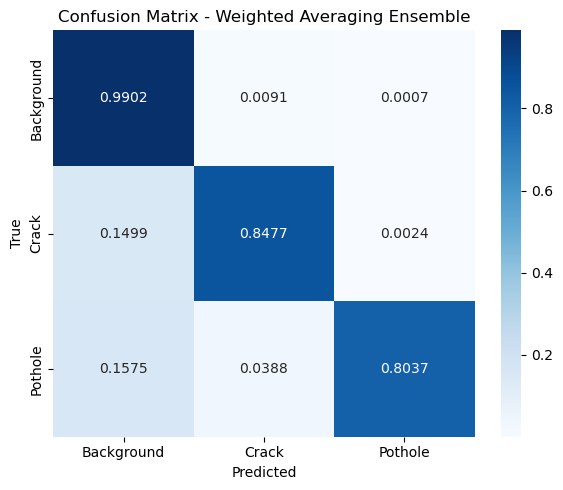

In [13]:
segformer, unet_r34, unet_mbv2 = load_models()
evaluate_weighted_ensemble(segformer, unet_r34, unet_mbv2, test_loader)

## AoD

In [6]:
import os
import pandas as pd
from tqdm import tqdm

# --- Weighted Ensemble Area Calculation Function ---
@torch.no_grad()
def compute_damage_areas(segformer, unet_r34, unet_mbv2, image_paths, output_csv_path):
    # IoU-based weights
    iou_mnv2 = 0.6637
    iou_rn32 = 0.6985
    iou_segformer = 0.6189

    total = iou_mnv2 + iou_rn32 + iou_segformer
    w_mnv2 = iou_mnv2 / total
    w_rn32 = iou_rn32 / total
    w_seg = iou_segformer / total

    print(f"\n📌 Using Weights => ResNet34: {w_rn32:.4f}, MNV2: {w_mnv2:.4f}, SegFormer-B2: {w_seg:.4f}")

    results = []

    for img_path in tqdm(image_paths, desc="🧮 Calculating Damage Areas"):
        # Preprocess
        img_unet = preprocess_unet_image(img_path).to(device)
        img_segformer = preprocess_segformer_image(img_path).to(device)

        # Predictions
        prob_r34 = F.softmax(unet_r34(img_unet), dim=1)
        prob_mbv2 = F.softmax(unet_mobilenet(img_unet), dim=1)
        out_segformer = segformer(pixel_values=img_segformer).logits
        out_segformer = F.interpolate(out_segformer, size=(640, 1024), mode="bilinear", align_corners=False)
        prob_segformer = F.softmax(out_segformer, dim=1)

        # Weighted averaging
        weighted_prob = (w_seg * prob_segformer) + (w_rn32 * prob_r34) + (w_mnv2 * prob_mbv2)
        pred_mask = torch.argmax(weighted_prob, dim=1).squeeze(0).cpu().numpy()

        # Area calculation
        crack_area = int((pred_mask == 1).sum())
        pothole_area = int((pred_mask == 2).sum())
        total_damage = crack_area + pothole_area

        results.append({
            "Image Name": os.path.basename(img_path),
            "Crack Area": crack_area,
            "Pothole Area": pothole_area,
            "Total Damage Area": total_damage
        })

    # Save CSV
    df = pd.DataFrame(results)
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    df.to_csv(output_csv_path, index=False)
    print(f"\n✅ Results saved to: {output_csv_path}")

In [7]:
# All test/train/val image folders
image_dirs = [
    r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\images",
    r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\train\images",
    r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\val\images",
]

# Collect all image paths
image_paths = []
for d in image_dirs:
    image_paths += [
        os.path.join(d, f)
        for f in os.listdir(d)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]

# Path to save results
output_csv = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\damage_area_results.csv"

# Call the function (assuming models are loaded already)
compute_damage_areas(segformer, unet_resnet, unet_mobilenet, image_paths, output_csv)


📌 Using Weights => ResNet34: 0.3526, MNV2: 0.3350, SegFormer-B2: 0.3124


🧮 Calculating Damage Areas: 100%|█████████████████████████████████████████████████| 2235/2235 [04:30<00:00,  8.26it/s]


✅ Results saved to: C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\damage_area_results.csv


In [9]:
# adding state and highway name
import pandas as pd
import re
from tqdm import tqdm

# File path
file_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\damage_area_results.csv"

# Load CSV
df = pd.read_csv(file_path)

# Enable tqdm for pandas
tqdm.pandas()

# Extract state from image name
def extract_state(image_name):
    if "_RS_" in image_name:
        return "RS"
    elif "_DF_" in image_name:
        return "DF"
    elif "_ES_" in image_name:
        return "ES"
    else:
        return "Unknown"

# Extract highway number (first 2–3 digit number after state code)
def extract_highway(image_name):
    match = re.search(r"_([A-Z]{2})_(\d{2,3})", image_name)
    if match:
        return match.group(2)
    return "Unknown"

# Apply functions with progress bar
df["State"] = df["Image Name"].progress_apply(extract_state)
df["Highway"] = df["Image Name"].progress_apply(extract_highway)

# Save changes to the same file
df.to_csv(file_path, index=False)

print(f"✅ CSV updated and saved at:\n{file_path}")

100%|██████████████████████████████████████████████████████████████████████████| 2235/2235 [00:00<00:00, 430130.74it/s]

✅ CSV updated and saved at:
C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\damage_area_results.csv


In [4]:
import pandas as pd

# File paths
input_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\damage_area_results.csv"
output_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD list.csv"

# Load the CSV
df = pd.read_csv(input_path)

# Ensure State and Highway columns exist and are strings
df['State'] = df['State'].astype(str)
df['Highway'] = df['Highway'].astype(str)

# Group by State and Highway, calculate:
# - Total damage area
# - Count of images (rows)
summary_df = (
    df.groupby(['State', 'Highway'])
    .agg(
        Total_Damage_Area=('Total Damage Area', 'sum'),
        Image_Count=('Total Damage Area', 'count')  # counts non-null rows = # images
    )
    .reset_index()
)

# Sort by Total Damage Area in descending order
summary_df = summary_df.sort_values(by='Total_Damage_Area', ascending=False)

# Save to new file
summary_df.to_csv(output_path, index=False)

print("✅ AoD list saved with image counts. Each State x Highway pair is unique.")

✅ AoD list saved with image counts. Each State x Highway pair is unique.


In [6]:
import pandas as pd
import overpy
from tqdm import tqdm

# Load AoD list
path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD list.csv"
df = pd.read_csv(path)

# Add BR prefix
df["HighwayRef"] = "BR-" + df["Highway"].astype(str).str.zfill(3)

# Get unique (State, HighwayRef) pairs
unique_refs = df[["State", "HighwayRef"]].drop_duplicates()

# Define state bounding boxes (min_lat, min_lon, max_lat, max_lon)
STATE_BBOX = {
    "ES": (-21.5, -41.2, -18.5, -39.0),
    "RS": (-33.75, -57.6, -27.0, -49.7),
    "DF": (-16.06, -48.3, -15.45, -47.3),
}

# Initialize Overpass API
api = overpy.Overpass()

def query_highway_info(ref_code, bbox):
    query = f"""
    [out:json][timeout:60];
    (
      way["ref"="{ref_code}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
    );
    out tags;
    """
    try:
        result = api.query(query)
        lanes = []
        speeds = []

        for way in result.ways:
            tags = way.tags
            if 'lanes' in tags:
                lanes.append(tags['lanes'])
            if 'maxspeed' in tags:
                speeds.append(tags['maxspeed'])

        return {
            "Num Samples": len(result.ways),
            "Speed Limit(s)": ", ".join(set(speeds)) if speeds else None,
            "Lane Count(s)": ", ".join(set(lanes)) if lanes else None
        }
    except Exception as e:
        print(f"⚠️ Failed for {ref_code}: {e}")
        return {
            "Num Samples": 0,
            "Speed Limit(s)": None,
            "Lane Count(s)": None
        }

# Dictionary to store results
results = {}

# Query each highway within its bounding box
print("🔍 Querying OSM for highway metadata...")
for _, row in tqdm(unique_refs.iterrows(), total=len(unique_refs)):
    state = row["State"]
    ref = row["HighwayRef"]
    bbox = STATE_BBOX.get(state)

    if bbox:
        results[(state, ref)] = query_highway_info(ref, bbox)
    else:
        print(f"❌ Skipping {ref} in unknown state: {state}")
        results[(state, ref)] = {
            "Num Samples": 0,
            "Speed Limit(s)": None,
            "Lane Count(s)": None
        }

# Convert results to DataFrame
meta_df = pd.DataFrame.from_dict(results, orient='index').reset_index()
meta_df.columns = ["State", "HighwayRef", "Num Samples", "Speed Limit(s)", "Lane Count(s)"]

# Merge with original AoD list
final_df = pd.merge(df, meta_df, on=["State", "HighwayRef"], how="left")

# Save output
save_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD with OSM Metadata.csv"
final_df.to_csv(save_path, index=False)
print(f"✅ Saved enriched AoD list to:\n{save_path}")

🔍 Querying OSM for highway metadata...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.32s/it]

✅ Saved enriched AoD list to:
C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD with OSM Metadata.csv


In [7]:
import overpy
import pandas as pd
from shapely.geometry import LineString
from tqdm import tqdm

# --- Setup ---
api = overpy.Overpass()
STATE_BBOX = {
    "ES": (-21.5, -41.2, -18.5, -39.0),
    "RS": (-33.75, -57.6, -27.0, -49.7),
    "DF": (-16.06, -48.3, -15.45, -47.3),
}

# --- Function: Query weighted highway metadata ---
def query_weighted_highway(ref, bbox):
    query = f"""
    [out:json][timeout:60];
    (
      way["ref"="{ref}"]({bbox[0]},{bbox[1]},{bbox[2]},{bbox[3]});
    );
    out body;
    >;
    out skel qt;
    """
    result = api.query(query)

    # Build node ID → coordinates map
    nodes = {n.id: (float(n.lon), float(n.lat)) for n in result.nodes}

    total_len = 0.0
    lanes_acc, speed_acc = 0.0, 0.0

    for way in result.ways:
        try:
            coords = [nodes[n.id] for n in way.nodes if n.id in nodes]
            if len(coords) < 2:
                continue

            length = LineString(coords).length
            total_len += length

            # Weighted sum for lanes
            lanes = way.tags.get('lanes')
            if lanes:
                try:
                    lanes_acc += float(lanes) * length
                except:
                    pass

            # Weighted sum for speed
            speed = way.tags.get('maxspeed')
            if speed:
                try:
                    speed_val = float(speed.split()[0])
                    speed_acc += speed_val * length
                except:
                    pass

        except Exception:
            continue

    if total_len == 0:
        return None

    avg_lanes = round(lanes_acc / total_len, 2) if lanes_acc else None
    avg_speed = round(speed_acc / total_len, 1) if speed_acc else None

    return {
        "Avg Lanes": avg_lanes,
        "Avg Speed": avg_speed,
        "Total Segments": len(result.ways)
    }

# --- Load AoD list ---
aod = pd.read_csv(r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD list.csv")
aod["RefFull"] = "BR-" + aod["Highway"].astype(str).str.zfill(3)
unique_refs = aod.drop_duplicates(['State', 'RefFull'])

# --- Query each unique (State, Highway) pair ---
out = []
print("🔍 Querying OSM for each highway...")
for _, row in tqdm(unique_refs.iterrows(), total=len(unique_refs)):
    state, ref = row.State, row.RefFull
    bbox = STATE_BBOX.get(state)

    if not bbox:
        print(f"⚠️ Unknown state: {state}")
        meta = None
    else:
        try:
            meta = query_weighted_highway(ref, bbox)
        except Exception as e:
            print(f"❌ Error querying {ref} in {state}: {e}")
            meta = None

    meta = meta or {
        "Avg Lanes": None,
        "Avg Speed": None,
        "Total Segments": 0
    }
    out.append({**row.to_dict(), **meta})

# --- Save results ---
out_df = pd.DataFrame(out)
out_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD_osm_weighted.csv"
out_df.to_csv(out_path, index=False)
print(f"\n✅ Metadata saved to:\n{out_path}")

🔍 Querying OSM for each highway...


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:23<00:00,  2.12s/it]


✅ Metadata saved to:
C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD_osm_weighted.csv


In [8]:
import pandas as pd

# Load enriched OSM + AoD data
input_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD_osm_weighted.csv"
df = pd.read_csv(input_path)

# --- Add Population and Urbanization data ---
state_stats = {
    "DF": {"Population": 2817381, "Urbanization": 96.4},
    "ES": {"Population": 3833712, "Urbanization": 85.2},
    "RS": {"Population": 10882965, "Urbanization": 84.4}
}

df["Population"] = df["State"].map(lambda x: state_stats.get(x, {}).get("Population"))
df["Urbanization"] = df["State"].map(lambda x: state_stats.get(x, {}).get("Urbanization"))

# --- Compute Raw State Specific Metric ---
df["State Specific Metric Raw"] = df["Population"] * df["Urbanization"]

# --- Compute Raw Road Specific Metric (without highway weight) ---
df["Road Specific Metric Raw"] = (
    df["Avg Lanes"].fillna(0) *
    df["Avg Speed"].fillna(0)
)

# --- Normalize State Specific Metric ---
state_min = df["State Specific Metric Raw"].min()
state_max = df["State Specific Metric Raw"].max()
df["State Specific Metric"] = 1 + (df["State Specific Metric Raw"] - state_min) * 99 / (state_max - state_min)

# --- Normalize Road Specific Metric ---
road_min = df["Road Specific Metric Raw"].min()
road_max = df["Road Specific Metric Raw"].max()
df["Road Specific Metric"] = 1 + (df["Road Specific Metric Raw"] - road_min) * 99 / (road_max - road_min)

# --- Traffic Severity Score (using normalized values) ---
df["Traffic Severity Score Raw"] = (
    df["State Specific Metric"] *
    df["Road Specific Metric"]
)

# --- Normalize Traffic Severity Score ---
traffic_min = df["Traffic Severity Score Raw"].min()
traffic_max = df["Traffic Severity Score Raw"].max()
df["Traffic Severity Score"] = 1 + (df["Traffic Severity Score Raw"] - traffic_min) * 99 / (traffic_max - traffic_min)

# --- Normalize Total_Damage_Area from 1 to 100 ---
if "Total_Damage_Area" in df.columns:
    damage_min = df["Total_Damage_Area"].min()
    damage_max = df["Total_Damage_Area"].max()
    df["Total_Damage_Area"] = 1 + (df["Total_Damage_Area"] - damage_min) * 99 / (damage_max - damage_min)

# --- Save final updated file ---
output_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD_osm_enriched.csv"
df.to_csv(output_path, index=False)

print(f"✅ Final enriched file saved at:\n{output_path}")

✅ Final enriched file saved at:
C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD_osm_enriched.csv


In [9]:
import pandas as pd

# Load the enriched CSV
input_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\AoD_osm_enriched.csv"
df = pd.read_csv(input_path)

# Drop rows for BR-010 and BR-080
df = df[~df["RefFull"].isin(["BR-010", "BR-080"])]

# Rename RefFull to Highway Name
df.rename(columns={"RefFull": "Highway Name"}, inplace=True)

# Select required columns
final_df = df[["State", "Highway Name", "Total_Damage_Area", "Traffic Severity Score"]]

# Save to new file
output_path = r"C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\Final List.csv"
final_df.to_csv(output_path, index=False)

print(f"✅ Final list saved at:\n{output_path}")

✅ Final list saved at:
C:\Users\SHREY\Desktop\gnctd\Area of Damage Results\Final List.csv


In [5]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import pad
from tqdm import tqdm

# --- Ensemble Weights ---
iou_mnv2 = 0.6637
iou_rn32 = 0.6985
iou_segformer = 0.6189
total = iou_mnv2 + iou_rn32 + iou_segformer
w_mnv2 = iou_mnv2 / total
w_rn32 = iou_rn32 / total
w_seg = iou_segformer / total

# --- Inference Preprocessing ---
def preprocess_for_unets(img):
    if img.height < 640:
        pad_h = 640 - img.height
        img = pad(img, (0, pad_h // 2, 0, pad_h - pad_h // 2), fill=0)
    return transforms.ToTensor()(img).unsqueeze(0)

def preprocess_for_segformer(img):
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0)

# --- Weighted Ensemble Prediction ---
@torch.no_grad()
def weighted_ensemble_predict(img_path):
    img = Image.open(img_path).convert("RGB")

    img_unet = preprocess_for_unets(img).to(device)
    img_segformer = preprocess_for_segformer(img).to(device)

    # SegFormer
    out_seg = segformer(pixel_values=img_segformer).logits
    out_seg = torch.nn.functional.interpolate(out_seg, size=(640, 1024), mode="bilinear", align_corners=False)
    prob_seg = torch.nn.functional.softmax(out_seg, dim=1)

    # UNet ResNet34
    out_r34 = unet_resnet(img_unet)
    prob_r34 = torch.nn.functional.softmax(out_r34, dim=1)

    # UNet MobileNetV2
    out_mbv2 = unet_mobilenet(img_unet)
    prob_mbv2 = torch.nn.functional.softmax(out_mbv2, dim=1)

    # Weighted prediction
    weighted_prob = w_seg * prob_seg + w_rn32 * prob_r34 + w_mnv2 * prob_mbv2
    pred_mask = torch.argmax(weighted_prob, dim=1).squeeze(0).cpu().numpy()
    return pred_mask, img_unet.squeeze(0)

# --- Colorize Segmentation Mask ---
def colorize_mask(mask):
    color_map = {
        0: (0, 0, 0),         # background (black)
        1: (255, 255, 0),     # crack (yellow)
        2: (255, 0, 0),       # pothole (red)
    }
    h, w = mask.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)
    for k, color in color_map.items():
        rgb[mask == k] = color
    return Image.fromarray(rgb)

# --- Extract State & Highway from Filename ---
def extract_state_highway(filename):
    parts = filename.split("_")
    if len(parts) >= 3:
        return parts[1], f"BR-{parts[2]}"
    return None, None

# --- Paths ---
image_dirs = [
    r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\train\images",
    r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\val\images",
    r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset\test\images"
]
output_dir = r"C:\Users\SHREY\Desktop\gnctd\frontend\Visualization"
os.makedirs(output_dir, exist_ok=True)

# --- Target Combinations ---
target_combos = {
    ("RS", "BR-290"), ("DF", "BR-251"), ("RS", "BR-386"),
    ("DF", "BR-020"), ("DF", "BR-070"), ("ES", "BR-259"),
    ("DF", "BR-060"), ("ES", "BR-101"), ("ES", "BR-482")
}

# --- Generate Visualizations for ALL matching combos (no max limit) ---
for image_dir in image_dirs:
    for fname in tqdm(os.listdir(image_dir), desc=f"🎨 {os.path.basename(image_dir)}"):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        state, highway = extract_state_highway(fname)
        if (state, highway) not in target_combos:
            continue

        img_path = os.path.join(image_dir, fname)
        pred_mask, padded_img_tensor = weighted_ensemble_predict(img_path)

        # Blend with transparency
        base_img = transforms.ToPILImage()(padded_img_tensor.cpu())
        overlay = colorize_mask(pred_mask)
        blended = Image.blend(base_img, overlay, alpha=0.5)

        save_path = os.path.join(output_dir, f"{state}_{highway}_{fname}")
        blended.save(save_path)

print("✅ All visualizations saved.")

🎨 images: 100%|█████████████████████████████████████████████████████████████████████| 224/224 [00:35<00:00,  6.27it/s]

✅ All visualizations saved.
